<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
#os.listdir(path)

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import argparse, os, sys
import cv2
from PIL import Image
import json
import pandas as pd
import pdb
from scipy.spatial import procrustes
from sklearn.decomposition import PCA

dataset_helen_train_path="datasets/helen/trainset"
dataset_helen_test_path="datasets/helen/testset"

In [3]:
with open("datasets/cropped_helen/helen_cropped_train_pts.json",'r') as htrain:
  htrain_pts = json.load(htrain)
with open("datasets/cropped_helen/helen_cropped_test_pts.json",'r') as htest:
  htest_pts = json.load(htest)

# Original Faces

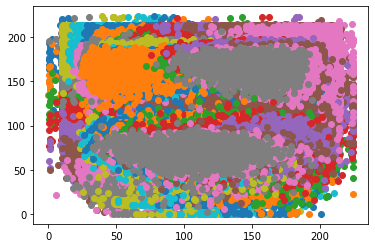

In [4]:
# plot face, same point same color
for i in range(68):
  x = [0]*2000
  y = [0]*2000
  j = 0
  for key in htrain_pts.keys():
    x[j] = htrain_pts[key][i][0]
    y[j] = 224-htrain_pts[key][i][1]
    j+=1
  plt.scatter(x,y)

Text(0.5, 1.0, 'Mean Face, Helen Dataset')

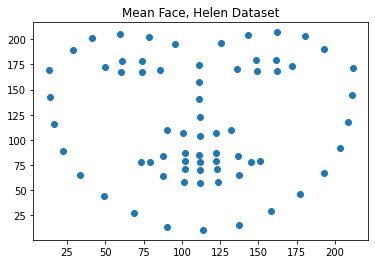

In [5]:
# mean shape
mean_shape_original = np.zeros(136)

xbar = [0]*68
ybar = [0]*68
for i in range(68):
  x = 0
  y = 0
  j = 0
  for key in htrain_pts.keys():
    x += htrain_pts[key][i][0]
    y += htrain_pts[key][i][1]
    j+=1
  xbar[i] = x/2000
  ybar[i] = 224-y/2000
  mean_shape_original[2*i] = x/2000
  mean_shape_original[2*i+1] = 224-y/2000
plt.scatter(xbar,ybar)
plt.title('Mean Face, Helen Dataset')

# PCA

In [10]:
ndim = 20

In [27]:
data_pca = np.zeros((2000,68,2))
i=0
for key in htrain_pts.keys():
  data_pca[i,:,:] = htrain_pts[key]
  i+=1
data_pca = data_pca.reshape(2000,-1)
data_pca[:,1::2]=224-data_pca[:,1::2]

In [28]:
mean_shape = np.sum(data_pca,axis=0)/2000
#mean_shape[1::2]=224-mean_shape[1::2]
pca = PCA(n_components=ndim)
pca.fit(data_pca)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0.5, 1.0, 'Mean shape before pca')

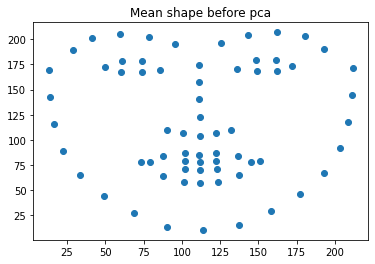

In [29]:
x = mean_shape[::2]
y = mean_shape[1::2]
plt.scatter(x,y)
plt.title('Mean shape before pca')

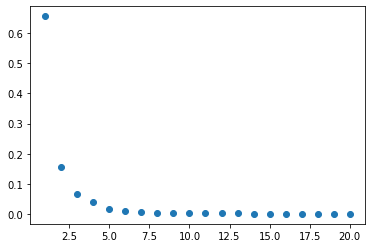

In [30]:
plt.scatter(np.arange(1,ndim+1), pca.explained_variance_ratio_)

In [31]:
np.sum(pca.explained_variance_ratio_)

0.988392134374842

In [32]:
X_new = pca.transform(data_pca) # (2000, ndim)

Text(0.5, 1.0, 'First face after pca')

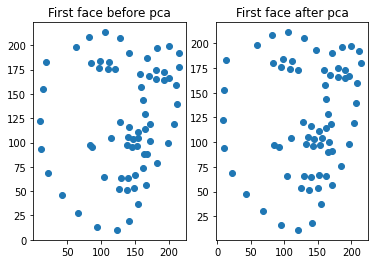

In [33]:
first = data_pca[0,:].reshape(-1)
x = first[::2]
y = first[1::2]
plt.subplot(121)
plt.scatter(x,y)
plt.title('First face before pca')

pca_face = mean_shape.copy()
#pca_face = np.zeros(136,)
for i in range(ndim):
  pca_face+=X_new[0,i]*pca.components_[i,:]

x = pca_face[::2]
y = pca_face[1::2]
plt.subplot(122)
plt.scatter(x,y)
plt.title('First face after pca')

In [42]:
np.save("datasets/cropped_helen/helen_train.npy",X_new)
np.save("datasets/cropped_helen/mean_shape.npy",mean_shape)
np.save("datasets/cropped_helen/eig_vecs.npy",pca.components_)

In [37]:
def nme_ocular(predict, actual):
  # predict(N,136), predicted point locations
  # actual(N,136), actual point locations
  N = predict.shape[0]
  squared_dist = np.sum((predict - actual)**2, axis=1) #(N)
  ocular_dist = np.sqrt((actual[:,36]-actual[:,45])**2 + (actual[:,37]-actual[:,46])**2) # No.37 and No.46
  nme_ocular = np.sum(squared_dist / ocular_dist)/N
  return nme_ocular.item()

In [40]:
reconstruct = np.dot(X_new,pca.components_)+mean_shape

In [41]:
nme_ocular(reconstruct,data_pca)

3.1344717625311094